> Texto fornecido sob a Creative Commons Attribution license, CC-BY. Todo o código está disponível sob a FSF-approved BSD-3 license.<br>
> (c) Original por Lorena A. Barba, Gilbert F. Forsyth em 2017, traduzido por Felipe N. Schuch em 2020.<br>
> [@LorenaABarba](https://twitter.com/LorenaABarba) - [@fschuch](https://twitter.com/fschuch)

12 passos para Navier-Stokes
======
***

Na etapa anterior, resolvemos a [Equação 2D de Burgers](./10_Step_8.ipynb): uma equação importante no estudo da mecânica dos fluidos, pois contém a não linearidade convectiva completa das equações do escoamento. Com esse exercício, também construímos a experiência para codificar incrementalmente um solucionador de Navier-Stokes.

Nas próximas duas etapas, resolveremos a equação de Laplace e depois de Poisson. Vamos então juntar tudo!

Passo 9: Equação de Laplace 2D
----
***

Aqui está a equação de Laplace em 2D:

$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = 0$$

Sabemos como discretizar uma derivada de 2ª ordem. Mas pense nisso por um minuto - a equação de Laplace tem as características típicas dos fenômenos de difusão. Por esse motivo, ele deve ser discretizado com *diferenças centrais*, para que a discretização seja consistente com a física que queremos simular.

A equação discretizada é:

$$\frac{p_{i+1, j}^n - 2p_{i,j}^n + p_{i-1,j}^n}{\Delta x^2} + \frac{p_{i,j+1}^n - 2p_{i,j}^n + p_{i, j-1}^n}{\Delta y^2} = 0$$

Observe que a Equação de Laplace não tem dependência de tempo - não há $ p ^ {n + 1} $. Em vez de rastrear uma onda no tempo (como nas etapas anteriores), a equação de Laplace calcula o estado de equilíbrio de um sistema sob as condições de contorno fornecidas.

Se você fez um curso em Transferência de Calor, reconhecerá a Equação de Laplace como a equação de calor em estado estacionário.

Em vez de calcular onde o sistema estará em algum momento $ t $, resolveremos iterativamente $ p_ {i, j} ^ n $ até que atenda a uma condição especificada. O sistema alcançará o equilíbrio apenas quando o número de iterações tender a $ \infty $, mas podemos aproximar o estado de equilíbrio iterando até que a mudança entre uma iteração e a próxima seja *muito* pequena.

Vamos reorganizar a equação discretizada, isolando $ p_ {i, j} ^ n $:

$$p_{i,j}^n = \frac{\Delta y^2(p_{i+1,j}^n+p_{i-1,j}^n)+\Delta x^2(p_{i,j+1}^n + p_{i,j-1}^n)}{2(\Delta x^2 + \Delta y^2)}$$

O uso de esquemas de diferença central de segunda ordem em ambas as direções é o método mais amplamente aplicado ao operador Laplace. Também é conhecido como o **operador de diferença de cinco pontos**, aludindo ao seu estêncil.

Vamos resolver a equação de Laplace numericamente assumindo um estado inicial de $p=0$ em todos os lugares. Em seguida, adicionamos condições de contorno da seguinte maneira:

$p=0$ em $x=0$

$p=y$ em $x=2$

$\frac{\partial p}{\partial y}=0$ em $y=0, \ 1$

Sob essas condições, existe uma solução analítica para a equação de Laplace:

$$p(x,y)=\frac{x}{4}-4\sum_{n=1,ímpar}^{\infty}\frac{1}{(n\pi)^2\sinh2n\pi}\sinh n\pi x\cos n\pi y$$

##### Exercício

Escreva seu próprio código para resolver a equação de Poisson usando laços `for`, no estilo de programação usado em nossas primeiras lições. Em seguida, considere a demonstração de como escrevê-lo usando as funções (abaixo) e modifique seu código nesse estilo. Você consegue pensar em razões para abandonar o estilo antigo e adotar a programação modular?

Outras dicas:

+ Visualize cada etapa do processo iterativo;
+ Pense no que as condições de contorno estão fazendo;
+ Pense no que a EDP está fazendo.

### Usando funções

Lembre-se da lição sobre como escrever [funções com Python](./11_Definindo_Funcoes_em_Python.ipynb)? Usaremos esse estilo de código neste exercício.

Vamos definir duas funções: uma que exibe nossos dados em um gráfico de projeção 3D e a outra que itera para resolver $p$ até que a alteração na [Norma L1][1] de $p$ seja menor que um valor especificado.

[1]: http://en.wikipedia.org/wiki/Norm_(mathematics)#Taxicab_norm_or_Manhattan_norm 

In [1]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
def plot2D(x, y, p):
    fig = pyplot.figure(figsize=(11, 7), dpi=100)
    ax = fig.gca(projection='3d')
    X, Y = numpy.meshgrid(x, y)
    surf = ax.plot_surface(X, Y, p[:].T, rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1)
    ax.view_init(30, 225)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

A função `plot2D` recebe três argumentos, um vetor x, um vetor y e nossa matriz p. Dados esses três valores, ele produz um gráfico de projeção em 3D, define os limites do gráfico e fornece um bom ângulo de visualização.

$$p_{i,j}^n = \frac{\Delta y^2(p_{i+1,j}^n+p_{i-1,j}^n)+\Delta x^2(p_{i,j+1}^n + p_{i,j-1}^n)}{2(\Delta x^2 + \Delta y^2)}$$

In [3]:
def laplace2d(p, y, dx, dy, l1norm_target):
    l1norm = 1
    pn = numpy.empty_like(p)

    while l1norm > l1norm_target:
        pn = p.copy()
        p[1:-1, 1:-1] = ((dy**2 * (pn[2:, 1:-1] + pn[0:-2, 1:-1]) +
                          dx**2 * (pn[1:-1, 2:] + pn[1:-1, 0:-2])) /
                        (2 * (dx**2 + dy**2)))
            
        p[0, :] = 0  # p = 0 @ x = 0
        p[-1, :] = y  # p = y @ x = 2
        p[:, 0] = p[:, 1]  # dp/dy = 0 @ y = 0
        p[:, -1] = p[:, -2]  # dp/dy = 0 @ y = 1
        l1norm = (numpy.sum(numpy.abs(p[:]) - numpy.abs(pn[:])) /
                numpy.sum(numpy.abs(pn[:])))
     
    return p

`laplace2d` recebe cinco argumentos, a matriz `p`, o vetor `y`, `dx`, `dy` e o valor `l1norm_target`. Esse último valor define o quão perto a matriz `p` deve estar em duas iterações consecutivas antes da quebra do loop e retorna o valor calculado` p`.

Observe que, ao executar as células acima em seu próprio notebook, não haverá saída. Você definiu a função, mas ainda não a invocou. Agora está disponível para você usar, o mesmo que `numpy.linspace` ou qualquer outra função.  

In [4]:
##Declaração das variáveis
x = numpy.linspace(0, 2, num=31)
y = numpy.linspace(0, 1, num=31)
c = 1

#Parâmetros da malha
nx = x.size
ny = y.size
dx = (x[-1] - x[0]) / (nx - 1)
dy = (y[-1] - y[0]) / (ny - 1)

##Condição Inicial
p = numpy.zeros((nx, ny))  # Cria um vertor nx x ny de zeros

##Condições de contorno
p[0, :] = 0  # p = 0 @ x = 0
p[-1, :] = y  # p = y @ x = 2
p[:, 0] = p[:, 1]  # dp/dy = 0 @ y = 0
p[:, -1] = p[:, -2]  # dp/dy = 0 @ y = 1

Agora vamos usar nossa função `plot2D` para observar nossa condição inicial. Se a função foi definida corretamente, você deve começar a digitar `plot2D` e pressionar a tecla **tab** para obter as opções de preenchimento automático.

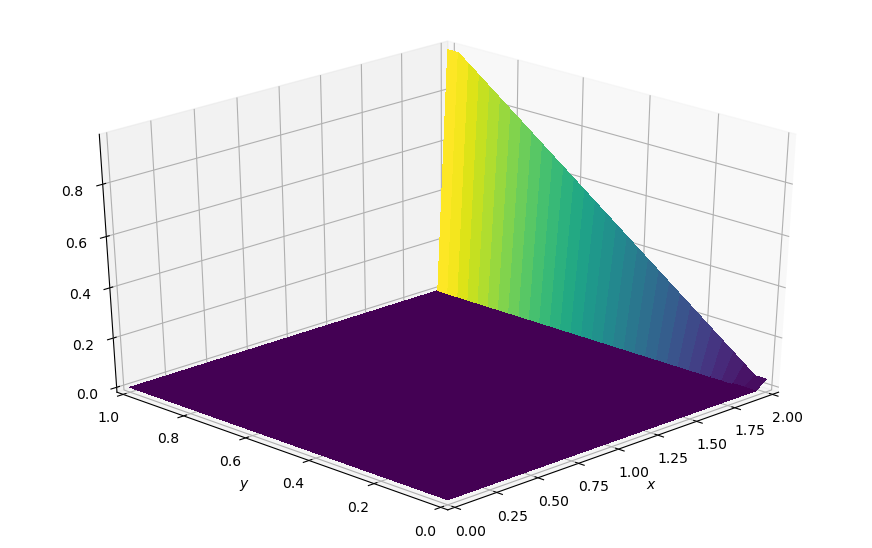

In [5]:
plot2D(x, y, p)

Funcionou! Este é o estado inicial do nosso problema, onde o valor de `p` é zero em todos os lugares, exceto ao longo de $x=2 $ em que $p = y$. Agora vamos tentar executar nossa função `laplace2d` com um critério L1 especificado de 0,0001.

**Dica:** se você estiver com problemas para lembrar a ordem em que as variáveis são enviadas para uma função, basta digitar `laplace2d(` e o iPython Notebook exibirá uma pequena caixa pop-up para te ajudar.

In [6]:
p = laplace2d(p, y, dx, dy, 1e-4)

Agora tente plotar esse novo valor de `p` com nossa função plot.

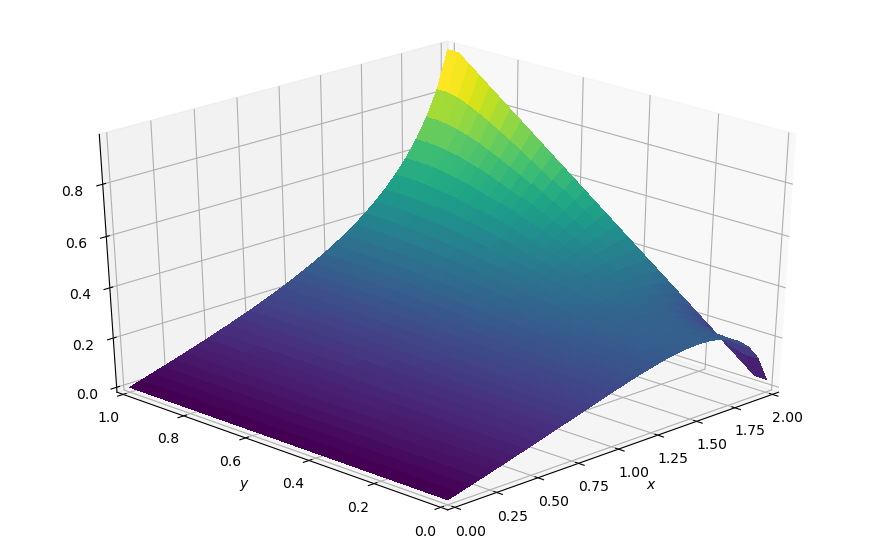

In [7]:
plot2D(x, y, p)

Material Complementar
-----
***

O [próximo passo](./13_Passo_10.ipynb) será resolver a equação de Poisson. Assista ao **Video Lesson 11** no YouTube para entender por que precisamos da equação de Poisson em CFD.

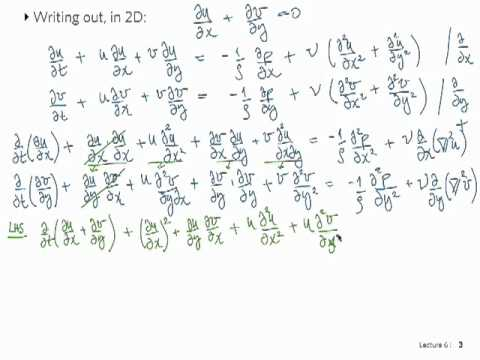

In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo('ZjfxA3qq2Lg')

E para uma explicação detalhada da discretização das equações de Laplace e Poisson (Passos 9 e 10), assista ao **Video Lesson 12** no YouTube:

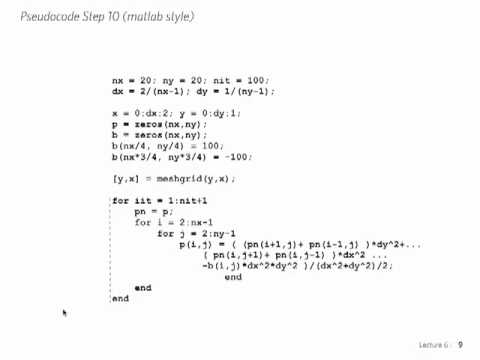

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo('iwL8ashXhWU')

In [10]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

> A célula acima executa o estilo para esse notebook. Nós modificamos o estilo encontrado no GitHub de [CamDavidsonPilon](https://github.com/CamDavidsonPilon), [@Cmrn_DP](https://twitter.com/cmrn_dp).